Press forward button to start the program
Starting the program


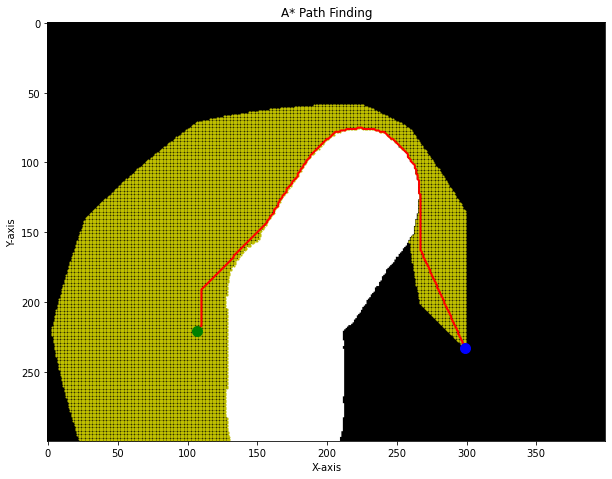

keypoint_angle :  [148 218]
keypoint_counter :  [266  98]
keypoint_angle :  [286  88]
keypoint_angle :  [326  90]
keypoint_angle :  [347 106]
keypoint_counter :  [382 226]
Mission accomplished
Press forward button to start the program


In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from camera_class import *
from thymio_class import *
from path import *

###########################################################
#Parameters
###########################################################
CAMERA_INDEX = 1 #0 if no webcam
CORNER_ARUCO_ID = [0, 1, 2, 10] #top-left, bottom-left, bottom-right, top-right
CORNER_ARUCO_SIZE = 65          #[mm]
MIN_SIZE = 500 #minimum blob size
COLOR_OBSTACLE = np.array([[30,20,120,65,50,170]]) #BGR
COLOR_GOAL = np.array([30,40,20,80,150,65])        #BGR
THYMIO_ID = 9
GRID_L = 400 #[pixels]
GRID_W = 300 #[pixels]
DISTANCE_THRESH = 75 #[mm]
###########################################################
#Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()

async def wait_for_start_button(node):
    await node.wait_for_variables({"button.forward"})
    await client.sleep(0.05)
    return (node.v.button.forward)
    
async def check_stop_button(node):
    await node.wait_for_variables({"button.center"})
    if (node.v.button.center == 1):  # Button pressed
        print("stopping")
        return True
    else :
        return False

async def main():
    node = await client.wait_for_node()
    aw(node.lock())
    
    print("Press forward button to start the program")
    beginning = False
    while(beginning == False) :
        beginning = await wait_for_start_button(node)
        time.sleep(0.3)
    cv2.destroyAllWindows()
    print("Starting the program")

    #Camera initialization
    cam=camera_class(CAMERA_INDEX,CORNER_ARUCO_ID,CORNER_ARUCO_SIZE, MIN_SIZE, COLOR_OBSTACLE, COLOR_GOAL)

    #Thymio initialization
    Thymio=Thymio_class(THYMIO_ID,cam)


    Path_planning = True #We want to have the path
    step = 0
    
    while True :
        step = step + 1
        #Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix=False)
        #Path Planning
        if Path_planning:
            if Thymio.target_keypoint==None: #only possible at first iteration to not take time later
                do_plot=True
            grid=discretize_image_eff(cam.thresholded_image,GRID_L, GRID_W)
            #Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            path, _, _ = a_star_search(grid, grid1_coord2grid2_coord(np.array([Thymio.xytheta_est[1],Thymio.xytheta_est[0]]),cam.persp_image,grid), grid1_coord2grid2_coord(np.array([cam.goal_center[1],cam.goal_center[0]]),cam.persp_image,grid),do_plot)

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]
            
            keypoints = find_keypoints(path_img)
            Thymio.keypoints=keypoints
            Thymio.target_keypoint=Thymio.keypoints[0]
            Thymio.keypoints=Thymio.keypoints[1:]
            
            do_plot=False
            Path_planning=False

        #Thymio Position and motor 
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()      

        #Kalman Filter
        v_L=[]
        v_R=[]
        #print("before kalman")
        for _ in range(10): #remove some variance
            await node.wait_for_variables({"motor.left.speed", "motor.right.speed"})
            v_L.append(node.v.motor.left.speed)
            v_R.append(node.v.motor.right.speed)
        v_L=np.mean(v_L)
        v_R=np.mean(v_R)
        Thymio.kalman_predict_state(v_L,v_R) #Predict
        if Thymio.Thymio_detected: #only update if Thymio detected
            Thymio.kalman_update_state()

        #Update history for final plot
        if((step % 30)==0) :
            Thymio.xytheta_meas_hist = np.vstack((Thymio.xytheta_meas_hist, Thymio.xytheta_meas))
            Thymio.xytheta_est_hist = np.vstack((Thymio.xytheta_est_hist, Thymio.xytheta_est))
        

        #Obstacle detection
        #TBD await get oprox sensor data
        obstacle=False #TBD
        if obstacle:
            Thymio.local_avoidance=True
            #TBD Thymio.local avoidance to update target motor speed
            #TBD await set speed (thymio.speed)
            draw_on_image(cam,Thymio,path_img)
            continue
        else:
            if Thymio.local_avoidance:
                Path_planning=True
                draw_on_image(cam,Thymio,path_img)
                continue




        #Target Achieved?
            else:
                if((step % 5)==0) :
                    #Next keypoint and controller:
                    #print("distance to keypoint: ", distance_to_goal(cam.pixbymm))
                    if((Thymio.distance_to_goal())<DISTANCE_THRESH) :
                        if(len(Thymio.keypoints)<=1): #Thymio found the goal
                            print("Mission accomplished") 
                            aw(node.stop())
                            aw(node.unlock())
                            draw_history(cam,Thymio,path_img, keypoints)
                            break
                        Thymio.keypoints=Thymio.keypoints[1:]
                        Thymio.target_keypoint=Thymio.keypoints[0]
                    #print("before moving")
                    v_m = Thymio.motion_control()
                    #print(f"v control {v_m}")
                    await node.set_variables(v_m)
                
                draw_on_image(cam,Thymio,path_img)
        if(await check_stop_button(node)) :
            aw(node.stop())
            aw(node.unlock())
            draw_history(cam,Thymio,path_img)
            break
    cam.cam.release()
    #cv2.destroyAllWindows()

# Run the main asynchronous function
while True :
    client.run_async_program(main)
    



In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())